# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Импортируем все необдходимое

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display, HTML


def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))


def describe(X: pd.DataFrame, y: pd. Series):
    X_copy = X.copy()
    X_copy["is_ultra"] = y
    return X_copy.describe()


RANDOM_SEED = 42


##  Откроем и изучим файл

In [3]:
df = pd.read_csv('datasets/users_behavior.csv')

In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


### Проверим типы данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


### Оптимизируем типы данных

In [6]:
df['messages']=df['messages'].astype("int16")
df['calls']=df['calls'].astype("int16")
df['minutes']=df['minutes'].astype("int16")
df['mb_used']=df['mb_used'].astype("float32")
df['is_ultra']=df['is_ultra'].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   calls     3214 non-null   int16   
 1   minutes   3214 non-null   int16   
 2   messages  3214 non-null   int16   
 3   mb_used   3214 non-null   float32 
 4   is_ultra  3214 non-null   category
dtypes: category(1), float32(1), int16(3)
memory usage: 34.8 KB


### Проверим  дубликаты

In [7]:
df.duplicated().sum()

0

#### Результаты проверки 
Дубликатов не найдено

### Проверка на корректность наименований столбцов

In [8]:
df.columns

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

#### Результаты проверки 
Имена столбцов заданы корректно

### Проверим значения содержащиеся в столбцах

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.000000,62.000000,82.000000,244.000000
minutes,3214.0,437.717797,234.559661,0.0,274.000000,430.000000,571.750000,1632.000000
messages,3214.0,38.281269,36.148326,0.0,9.000000,30.000000,57.000000,224.000000
mb_used,3214.0,17207.673828,7570.968262,0.0,12491.902588,16943.234375,21424.699707,49745.730469


### Вывод

1. Пропущенных значений нет
1. Типы столбцов в порядке
1. Дубликатов нет
2. Целевой признак не сбалансирован. Позже, надо будет произвести балансировку обучающей выборки с помощью imbalanced-learn

# Разобьем данные на выборки

## Разделим данные на целевой столбец и матрицу признаков

In [10]:
df_copy = df.copy()
X = df_copy.drop(columns=["is_ultra"])
y = df_copy["is_ultra"]

## Так как у нас нет скрытой тестовой выборки - сделаем свою

In [11]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X,
                            y,
                            test_size = 0.33,
                            random_state = RANDOM_SEED
                                       )


## Проверим обучающую выборку на мультиколлинеарность

<Axes: >

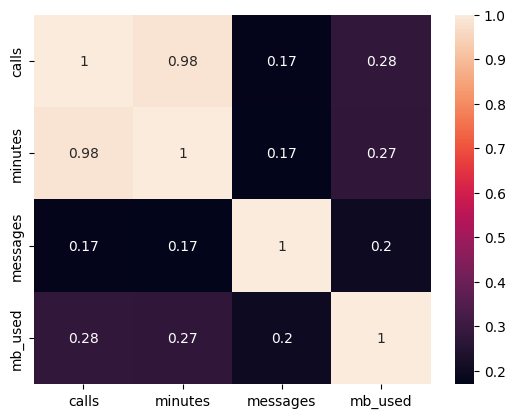

In [13]:
sns.heatmap(X_train.corr(), annot=True)

<div class="alert alert-info">
<b>annot=True выведет численные значения парных корреляций. Кстати говоря, если мы говорим о корреляции - важно понимать, как ее использовать:

https://www.dmitrymakarov.ru/opt/relationship-03/

раздел Корреляция
</b>
</div>

### Результаты проверки
Звонки и минуты имеют высокую коллинеарность. Учтем этот факт и проведем обучение моделей на скорректированных выборках.

## Зададим условия формирования выборок


In [321]:
BALANCED = True

# В зависимости от значения этих переменных выборка будет меняться и в конце появится сводный результат, который сохранится после каждого прогона
FULL = True
NO_CALLS = False
NO_MINUTES = False

<div class="alert alert-info">
<b>здорово
</b>
</div>


## Теперь разделим тестовую выборку на тестовую и валидационную

In [323]:
(X_valid,
 X_test,
 y_valid,
 y_test) = train_test_split(X_test,
                            y_test,
                            test_size = 0.5,
                            random_state = RANDOM_SEED
                                       )

## В зависимости от глобальных условий модицифруем признаки

In [324]:
if BALANCED:
    over = RandomOverSampler(sampling_strategy=1)
    X_train, y_train = over.fit_resample(X_train, y_train)
if NO_CALLS:
    X_train = X_train.drop(columns=["calls"])
    X_valid = X_valid.drop(columns=["calls"])
    X_test = X_test.drop(columns=["calls"])
elif NO_MINUTES:
    X_train = X_train.drop(columns=["minutes"])
    X_valid = X_valid.drop(columns=["minutes"])
    X_test = X_test.drop(columns=["minutes"])
# under = RandomUnderSampler(sampling_strategy=0.7)
# X, y = under.fit_resample(X, y)

#  Исследуем модели

## Random Forest

Поиск лучшего классификатора по <b>точности</b> предсказания и по <b>матрице ошибок</b>

In [351]:
best_RF = None
best_accuracy_RF = 0
best_est_RF = 0
best_depth_RF = 0
exit = False
est = 5
TARGET = (0, 0) # Ищем то, что приведет к меньшему числу ложных рекомендаций Смарт. Этот параметр в матрице должен быть минимальных среди моделей
min_target = len(X_valid)
parameters = []
for est in tqdm(range(1,15)):
    for depth in range(2, 10):
        RF = RandomForestClassifier(random_state = RANDOM_SEED,n_estimators = est, max_depth = depth)
        RF.fit(X_train, y_train)
        prediction_valid_RF = RF.predict(X_valid)
        cm = confusion_matrix(prediction_valid_RF, y_valid)
        accuracy_RF = accuracy_score(prediction_valid_RF, y_valid)
        if cm[TARGET[0]][TARGET[1]] < min_target:
            min_target = cm[TARGET[0]][TARGET[1]]
            best_RF_on_cm = RF
            best_accuracy_RF_on_cm = accuracy_RF
        
        parameters.append((est, depth, accuracy_RF))
        if best_accuracy_RF < accuracy_RF:
            best_RF = RF
            best_depth_RF = depth
            best_est_RF = est
            best_accuracy_RF = accuracy_RF
print(best_RF, best_RF_on_cm)
            

100%|██████████████████████████████████████████| 14/14 [00:08<00:00,  1.75it/s]

RandomForestClassifier(max_depth=9, n_estimators=6, random_state=42) RandomForestClassifier(max_depth=5, n_estimators=2, random_state=42)


## Decision Tree

In [326]:
best_DT = None
best_accuracy_DT = 0
best_depth_DT = 0
for depth in tqdm(range(2,20)):
    DT = DecisionTreeClassifier(random_state = RANDOM_SEED, max_depth = depth)
    DT.fit(X_train, y_train)
    prediction_valid_DT = DT.predict(X_valid)
    accuracy_DT = accuracy_score(prediction_valid_DT, y_valid)
    if best_accuracy_DT < accuracy_DT:
        best_DT = DT
        best_accuracy_DT = accuracy_DT
        best_depth_DT = depth

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 33.57it/s]


Лучшая модель Decision tree


## LogisticRegression

In [327]:
LR = LogisticRegression(random_state = RANDOM_SEED,max_iter= 1000,tol=1e-5,solver = 'lbfgs' )
LR.fit(X_train, y_train)
prediction_valid_LR = LR.predict(X_valid)
accuracy_LR = accuracy_score(prediction_valid_LR, y_valid)

# Проверка моделей на тестовой выборке

In [328]:
prediction_test_LR = LR.predict(X_test)
prediction_test_RF = best_RF.predict(X_test)
prediction_test_RF_on_cm = best_RF_on_cm.predict(X_test)
prediction_test_DT = best_DT.predict(X_test)

In [352]:
accuracy_LR_test = accuracy_score(prediction_test_LR, y_test)
accuracy_RF_test = accuracy_score(prediction_test_RF, y_test)
accuracy_RF_test_on_cm = accuracy_score(prediction_test_RF_on_cm, y_test)
accuracy_DT_test = accuracy_score(prediction_test_DT, y_test)

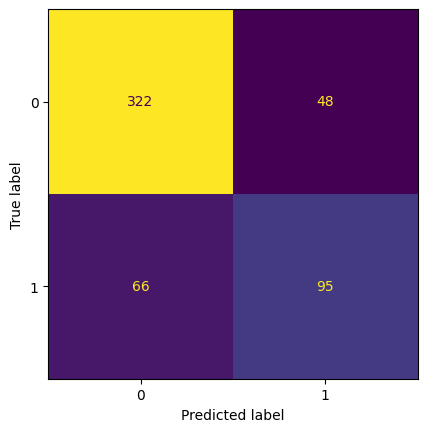

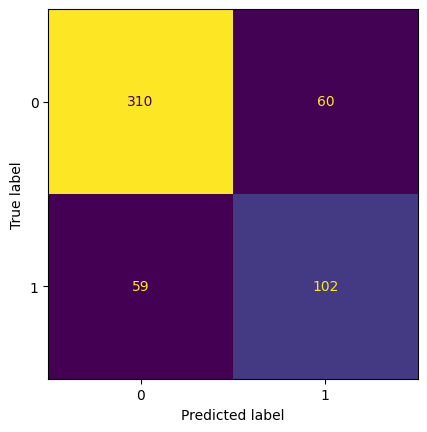

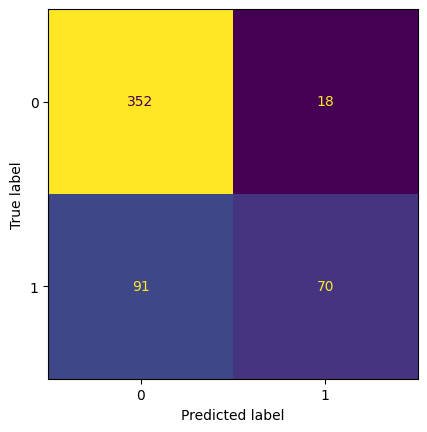

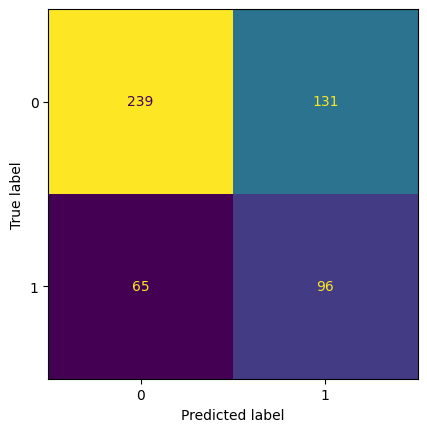

In [331]:
disp_rf = ConfusionMatrixDisplay.from_estimator(best_RF, X_test, y_test, colorbar=False)
disp_rf_cm = ConfusionMatrixDisplay.from_estimator(best_RF_on_cm, X_test, y_test, colorbar=False)
disp_dt = ConfusionMatrixDisplay.from_estimator(best_DT, X_test, y_test, colorbar=False)
disp_lr = ConfusionMatrixDisplay.from_estimator(LR, X_test, y_test, colorbar=False)

<div class="alert alert-warning">
    Из ниже представленных блоков следует запускать только те, которые соответствуют условиям
</div>

In [357]:
print("FULL", FULL)
print("NO_CALLS", NO_CALLS)
print("NO_MINUTES", NO_MINUTES)

FULL True
NO_CALLS False
NO_MINUTES False


### Результаты без усечения данных

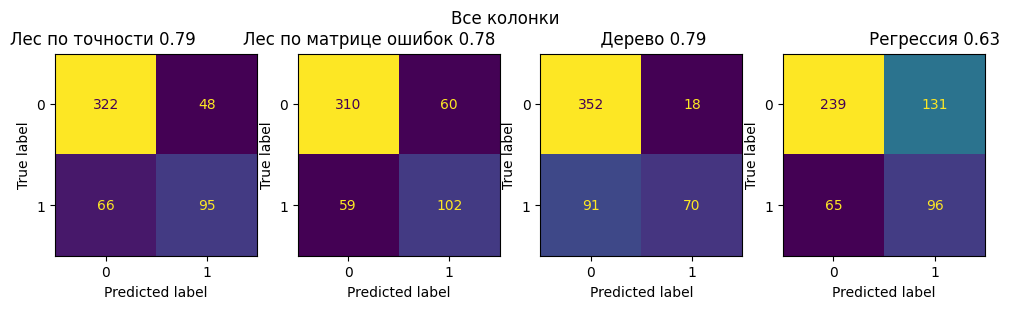

In [332]:
if FULL:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    disp_rf.plot(ax=axs[0], colorbar=False)
    disp_rf_cm.plot(ax=axs[1], colorbar=False)
    disp_dt.plot(ax=axs[2], colorbar=False)
    disp_lr.plot(ax=axs[3], colorbar=False)
    title = f"Лес по точности {accuracy_RF_test:.02f}         Лес по матрице ошибок {accuracy_RF_test_on_cm:.02f}                    Дерево {accuracy_DT_test:.02f}                               Регрессия {accuracy_LR_test:.02f}"
    plt.suptitle(f"Все колонки\n{title}")
    plt.show()

### Результаты по данным без звонков

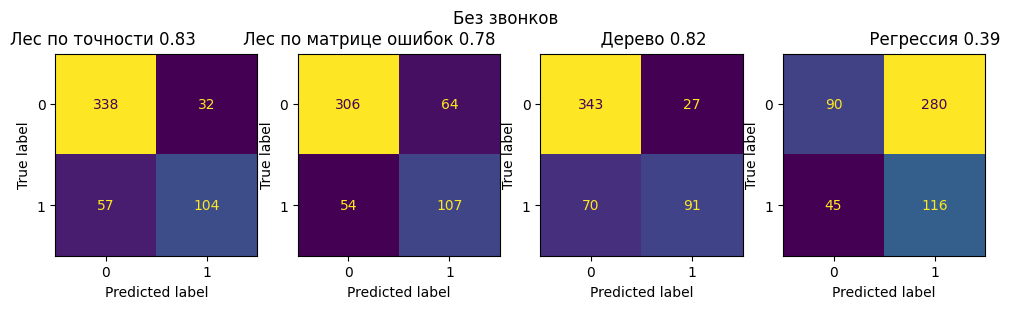

In [307]:
if NO_CALLS:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    disp_rf.plot(ax=axs[0], colorbar=False)
    disp_rf_cm.plot(ax=axs[1], colorbar=False)
    disp_dt.plot(ax=axs[2], colorbar=False)
    disp_lr.plot(ax=axs[3], colorbar=False)
    title = f"Лес по точности {accuracy_RF_test:.02f}         Лес по матрице ошибок {accuracy_RF_test_on_cm:.02f}                    Дерево {accuracy_DT_test:.02f}                               Регрессия {accuracy_LR_test:.02f}"
    plt.suptitle(f"Без звонков\n{title}")
    plt.show()

### Результаты по данным без минут

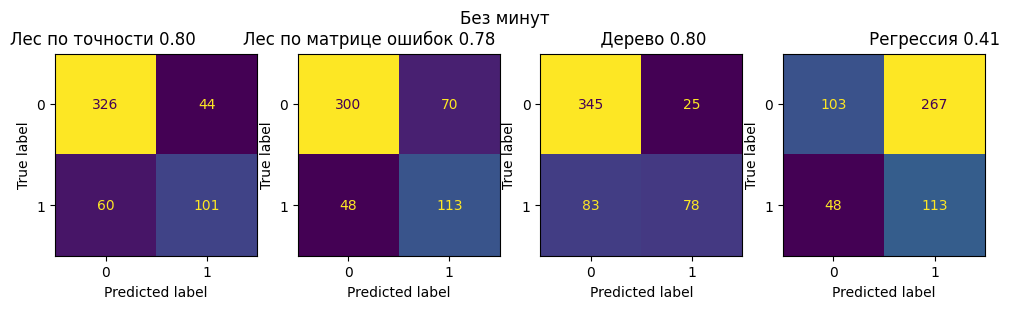

In [272]:
if NO_MINUTES:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    disp_rf.plot(ax=axs[0], colorbar=False)
    disp_rf_cm.plot(ax=axs[1], colorbar=False)
    disp_dt.plot(ax=axs[2], colorbar=False)
    disp_lr.plot(ax=axs[3], colorbar=False)
    title = f"Лес по точности {accuracy_RF_test:.02f}         Лес по матрице ошибок {accuracy_RF_test_on_cm:.02f}                    Дерево {accuracy_DT_test:.02f}                               Регрессия {accuracy_LR_test:.02f}"
    plt.suptitle(f"Без минут\n{title}")
    plt.show()

## Вывод



Лес и дерево показали неплохие результаты. При этом, на валидационной выборке результаты в некоторых итерациях достигали 86% точности. Это говорит о недостаточности данных для обучения модели для более высокой точности, что очевидно и без результатов сравнения.

Валидация успешности модели может осуществляться различными методами. Например, для леса был добавлен критерий - количество ложных рекомендаций трифа Смарт должно быть минимально. Такая модель имеет сниженную точность предсказаний, но в руках маркетологов позволила бы достичь большей прибыли, но это не точно.

*** Конец ознакомительного фрагмента. Для более точного аудита мы готовы произвести для вас более обширное исследование, результаты которого помогут вам извлечь максимум прибыли из вашего бизнеса.

<div class="alert alert-info">
<b>работа выглядит отлично. можно добавить сравнение различных методов при моделировании и их влиянии на целевую метрику, например, можно поместить результаты в таблицу и подсветить лучшие результаты:
</b>
</div>

|Модель|Признаки|Accuracy|
|------|--------|--------|
|дерево|все|0.79|
|**дерево**|**без calls**|**0.82**|
|дерево|без minutes|0.80|